# Python Analysis Example

In this first cell of the jupyter notebook, we start off with some text written in Markdown, allowing for an introduction to the topic. This is going to be an example of some of the more common sorts of analysis that I perform in MDAnalysis and MDTraj. I'll use headings to allow for easy navigation of the document in Jupyter Lab (click on the three lines on the left hand side to see the table of contents). I won't be doing a detailed breakdown of each of these steps here, as I've done so in [the linked tutorial](https://mccg.erc.monash.edu/Group%20Wiki/Molecular%20Dynamics/Analysis%20of%20Biomolecular%20MD%20Simulations/).

## MDAnalysis

We start off with MDAnalysis by importing all the packages needed, and then loading in our trajectories into MDAnalysis.

In [46]:
# [1]
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

# [2]
psfName = '2h8s_hbond.psf'
dcdName = '2h8s_prodRun_dry.dcd'
imagePath = 'imageOutput/'

# [3]
# if you're not running JupyterLab from the analysisFiles directory, you'll need to specify the path to this folder manually:
# mainPath = /Users/mrob0018/Desktop/analysisFiles/
# transPath1 = mainPath + 'trans_proline/replicate1/'

transPath1 = 'trans_proline/replicate1/'
transPath2 = 'trans_proline/replicate2/'
transPath3 = 'trans_proline/replicate3/'
transPathList = [transPath1, transPath2, transPath3]

cisPath1 = 'cis_proline/replicate1/'
cisPath2 = 'cis_proline/replicate2/'
cisPath3 = 'cis_proline/replicate3/'
cisPathList = [cisPath1, cisPath2, cisPath3]

# [4]
transU_1 = mda.Universe(transPath1 + psfName, transPath1 + dcdName)
transU_2 = mda.Universe(transPath2 + psfName, transPath2 + dcdName)
transU_3 = mda.Universe(transPath3 + psfName, transPath3 + dcdName)

cisU_1 = mda.Universe(cisPath1 + psfName, cisPath1 + dcdName)
cisU_2 = mda.Universe(cisPath2 + psfName, cisPath2 + dcdName)
cisU_3 = mda.Universe(cisPath3 + psfName, cisPath3 + dcdName)

prolineListNames = ['cis', 'trans']
nameDictConverter = {'cis': 'Cis-peptidyl Proline Vc1.1', 'trans': 'Trans-peptidyl Proline Vc1.1'}

With this done, we now have our data available for further work. However, it is best to align the data now, as further analysis requires aligned data. This functionally removes the random motion of the molecules of interest, allowing for differences in position to be attributed to conformational changes, rather than drifting around the water box.

In [33]:
# [1]
from MDAnalysis.analysis import align, rms 
# [2]
def massAlign(pathList, uName, pdbName, dcdName, repNum=3):  # Define a function to align a collection of trajectories
    for i in range (1, repNum+1):
        path = pathList[i-1]
        protU = eval(uName + str(i))
        refU = mda.Universe(path + pdbName, path + dcdName)  # Create a new reference universe of the same trajectory
        refU.trajectory[0]  # Make sure it's set to the first frame
        protU.trajectory[-1]
        aligner = align.AlignTraj(protU, refU, in_memory=True).run()  # We can afford to to it in-memory as they're stripped of water - less than 100MB each

# [3]
for name in prolineListNames:  # For each set of trajectories in our master list
    uName = name + "U_"  # Set the name 
    pathList = eval(name + "PathList")  # And then fetch the appropriate list of trajectories
    massAlign(pathList, uName, psfName, dcdName, repNum=3)  # And use the above-defined function

### Analysis

With our system aligned, we can start some actual analysis! Our first step is going to be validation, where we use RMSD over the course of the trajectory as a metric for the convergence of the overall simulation, looking for a plateau:

Text(0.5, 1.0, 'Trans-Peptidly Proline VC1.1 Trajectory RMSD')

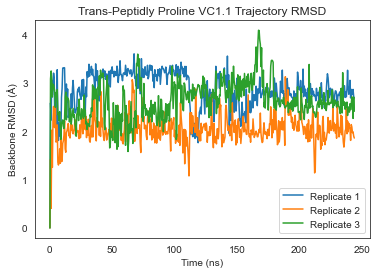

In [47]:
rmsdColumns = ['Frame', 'Time (ns)', 'Backbone RMSD (Å)']
for i in range(1,4):
	# [2]
    protU = eval("transU_" + str(i))
    RMSCalc = rms.RMSD(protU,
                      protU,
                      select='backbone',
                      ref_frame=0,
                      weights='mass')
    RMSCalc.run()
    # [3]
    RMSdf = pd.DataFrame(RMSCalc.rmsd, columns = rmsdColumns)  # Just setting column names for clarity later
    RMSdf['Time (ns)'] = RMSdf['Time (ns)']*10  # Inserted to account for the reduced-frame trajectory
    sns.lineplot(x='Time (ns)', y='Backbone RMSD (Å)', data = RMSdf, label=("Replicate " + str(i)))
# [4]
plt.title('Trans-Peptidly Proline VC1.1 Trajectory RMSD')

Text(0.5, 1.0, 'Cis-Peptidly Proline VC1.1 Trajectory RMSD')

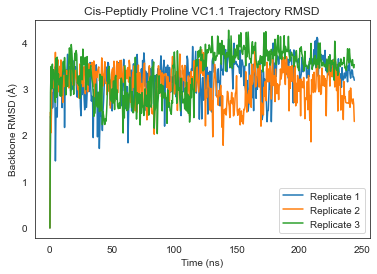

In [58]:
rmsdColumns = ['Frame', 'Time (ns)', 'Backbone RMSD (Å)']
for i in range(1,4):
	# [2]
    protU = eval("cisU_" + str(i))
    RMSCalc = rms.RMSD(protU,
                      protU,
                      select='backbone',
                      ref_frame=0,
                      weights='mass')
    RMSCalc.run()
    # [3]
    RMSdf = pd.DataFrame(RMSCalc.rmsd, columns = rmsdColumns)  # Just setting column names for clarity later
    RMSdf['Time (ns)'] = RMSdf['Time (ns)']*10  # Inserted to account for the reduced-frame trajectory
    sns.lineplot(x='Time (ns)', y='Backbone RMSD (Å)', data = RMSdf, label=("Replicate " + str(i)))
# [4]
plt.title('Cis-Peptidly Proline VC1.1 Trajectory RMSD')

As we can see a stable RMSD over time very quickly appears, and the convergence of this RMSD can be taken as evidence of the convergence of other important factors in the system - depending on what information you're trying to get out, it might be worthwhile looking at other possible metrics of convergence too. These can be 2D RMSD plots, showing the RMSD of each frame with respect to every other frame, or convergence of a property of interest - free energy, pressure, etc. The jagged nature of the figure generated above is something that might benefit from being smoothed out, if you were presenting it in a figure and you had more data points than the ~500 abriged points we have. To do so, you can create a running average of the RMSD:
`RMSdf['Rolling Average'] = RMSdf[['Backbone RMSD (Å)']].rolling(50).mean()`
And then plot this, instead of the backbone RMSD. 

With convergence noted as having occurred for the system, we can move on to more complicated analysis - in the example below, we're looking at a density plot of the relative frequency of the closest interaction distance between two selections across the entire simulation. We start off with a function that facilitates this analysis by generating a dataframe of the minimum distance between the two selections across a trajectory:

In [23]:
from MDAnalysis.analysis import distances

def distanceDFSetup(nameList, sel1, sel2,legendName = None, repCount = 3):
    # Needs three arguments: nameList is a list of universe names in the form 'name'U_repNum
    # sel1 and sel2 are MDAnalysis selection strings for use with the select_atoms command
    # An optional dictionary can be passed as legendName, which allows the use of full-text names for the legend
    # Returns a dataframe of the distance between sel1 and sel2 across each frame in each universe
    # Each value is marked with the universe's name and replicate number
    # [1]
    fullDFList = []
    for traj in nameList:
        if legendName is None:
            trajName = traj
        else:
            trajName = legendName[traj]
        # [2]
        for i in range(1,repCount+1):
            protU = eval(traj + "U_" + str(i))
            res1 = protU.select_atoms(sel1)
            res2 = protU.select_atoms(sel2)
            distSet = []
            # [3]
            for ts in protU.trajectory:
                dist = distances.distance_array(res1.positions, res2.positions)
                minDist = np.amin(dist)
                distSet.append(minDist)
            # [4]
            sourceName = [trajName]*len(distSet)
            currentDF = pd.DataFrame({'Distance': distSet, 'Source': sourceName, 'Replicate': 'Replicate ' + str(i)})
            fullDFList.append(currentDF)
    fullDF = pd.concat(fullDFList)
    return(fullDF)

We can then use the function to generate figures with relative ease:

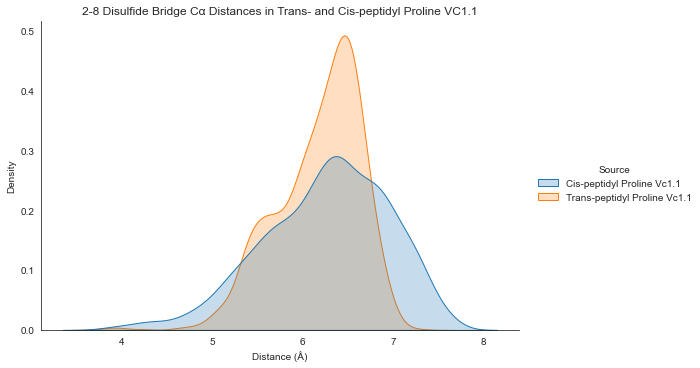

In [24]:
distanceDF = distanceDFSetup(prolineListNames,
                         sel1 = 'resid 2 and name CA',
                         sel2 = 'resid 8 and name CA',
                         legendName = nameDictConverter)

sns.displot(data=distanceDF, x='Distance', hue='Source', fill='Source', kind = "kde", aspect=1.5)
plt.title('2-8 Disulfide Bridge Cα Distances in Trans- and Cis-peptidyl Proline VC1.1')
plt.xlabel('Distance (Å)')

plt.savefig(imagePath + 'CaDist.png', bbox_inches="tight")

The figure generated above is simply the alpha carbon to alpha carbon distance between two residues joined by a disulfide linkage, but it's entirely possible to use the same analysis on different sources. For example, the minimum distance between the sidechain or backbone of two residues, or even the distance between two domains of a protein. For our final analysis using MDAnalysis, we perform RMSF analysis to look at the flexibily of each residue in the peptide:

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

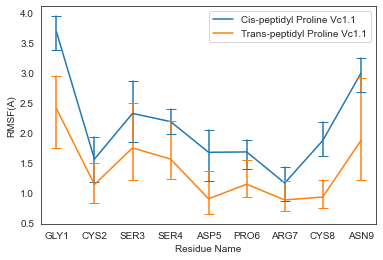

In [25]:
from MDAnalysis.analysis.rms import RMSF

# [1]
resCount = 0
calphas = transU_1.select_atoms("segid A and name CA")  # We need an initial selection, so just put in a universe already loaded
residueNames = calphas.resnames  # We get the residue names from our selection
for res in residueNames:  # For each residue name, we add the residue count to it to ensure uniqueness
    residueNames[resCount] = res + str(resCount+1)
    resCount += 1

# [2]
for traj in prolineListNames:
    rmsfList = []
    for i in range(1,4):
        protU = eval(traj + "U_" + str(i))
        protein = protU.select_atoms('not resname SOD CLA SW* TIP*')
        calphas = protein.select_atoms("name CA")
        rmsfer = RMSF(calphas, verbose=True).run()  # We select a trajectory, and run the rmsf calculation
        resCount = 0
        for rms in rmsfer.rmsf:  # To get the data in the right way, we create a list of the residue name and it's RMSF
            toAppend = [residueNames[resCount], rms]
            resCount += 1
            rmsfList.append(toAppend)  # And append this to a growing list of residues with their RMSF

# [3]
    RMSF_DF = pd.DataFrame(rmsfList, columns=["Residue Name", "RMSF(A)"])
    sns.lineplot(data=RMSF_DF, x="Residue Name", y="RMSF(A)", err_style="bars", err_kws={"capsize":5}, sort=False, label=nameDictConverter[traj])
plt.savefig(imagePath + 'fullRMSF.png', bbox_inches="tight")

From this, we can see that there are no statistically significant differences between the two sets of simulation with the exception of the highly-flexible GLY1 residue, and the biologically relevant CYS8 residue. This gives us an interesting pathway for further investigation - does the GLY1 residue play a role? How does the increased flexibilty of the CYS8 residue impact peptide function? These error bars show the default 95% confidence interval, a commonly used value that correlates with a p < 0.05 value.

## MDTraj

Not all analysis can easily be performed in MDAnalysis - in particular for our case, secondary structure determination doesn't work easily in program, due to licensing issues with the STRIDE program. There's talk of changing this in the future, but this is a good time to show you how MDTraj works as well! We start off with importing things in a very similary way to MDAnalysis' section:

In [60]:
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pdbName = '2h8s_hbond.psf'
dcdName = '2h8s_prodRun_dry.dcd'

trajListFullNames = ['cis', 'trans']
fullTrajNameDict = {'cis': 'Cis-peptidyl Proline Vc1.1', 'trans': 'Trans-peptidyl Proline Vc1.1'}

cisPath1 = 'cis_proline/replicate1/'
cisPath2 = 'cis_proline/replicate2/'
cisPath3 = 'cis_proline/replicate3/'
cisPathList = [cisPath1, cisPath2, cisPath3]

cisTraj1 = md.load(cisPath1+dcdName, top=cisPath1+pdbName)
cisTraj2 = md.load(cisPath2+dcdName, top=cisPath2+pdbName)
cisTraj3 = md.load(cisPath3+dcdName, top=cisPath3+pdbName)

transPath1 = 'trans_proline/replicate1/'
transPath2 = 'trans_proline/replicate2/'
transPath3 = 'trans_proline/replicate3/'
transPathList = [transPath1, transPath2, transPath3]

transTraj1 = md.load(transPath1+dcdName, top=transPath1+pdbName)
transTraj2 = md.load(transPath2+dcdName, top=transPath2+pdbName)
transTraj3 = md.load(transPath3+dcdName, top=transPath3+pdbName)

We then define a series of functions to help make this easier - they're fairly heavily commented for ease of understanding, and further explanation is available in the associated tutorial. I'm showing them here for ease of understanding, but I find it easier to put them in a separate folder - place a file called `mdFunctions.py` in the same folder as the working directory and run `import * from mdFunctions` to get them instead. That way they're the same between your different projects!

In [61]:
# The returnSecStruc function is defined to simplify this procedure; it has a series of arguments it takes in: traj is the input trajectory,
# select is a selection string like 'resid 3 to 8', secStrucType = 'H'/'C'/'E' for simple, simpBool = turn simple DSSP on and off
# And the byRes argument defines whether the propensity for each residue in the entire region is returned in addition to the region's propensity
def returnSecStruc(traj, selec, secStrucType, simpBool=True, byRes=False):
    secStrucSel = traj.topology.select(selec)
    secStrucArea = traj.atom_slice(secStrucSel)
    # Slice the input trajectory to the appropriate area, then calculate DSSP
    secStruc = md.compute_dssp(secStrucArea, simplified=simpBool) 
    # Make a list equal in length to the amount of residues 
    secStrucList = [0] * len(secStruc[0])  
    for frame in secStruc:
        resCounter = 0
        # For each frame in the DSSP results, see if the residue's DSSP matches the type being searched
        for residue in frame:
            if residue == secStrucType:
	            # If it does, increment the appropriate counter for that residue in the list  
                secStrucList[resCounter] += 1  
            resCounter += 1
    normalizedList = []
    totalValue = 0
    # Once we've got a list of how often our secondary structure type occurs, we loop through the per-residue list
    for residue in secStrucList:  
	    # We normalize the result, giving each residue a proportion of the simulation in that secondary structure
        fractional = residue/len(secStruc)  
        totalValue += fractional  
        # We add that normalized result to a counter, and append it to the normalized list
        normalizedList.append(fractional)  
    # When each residue has been searched, we calculate the percentage of that secondary structure propensity for the entire region
    proportionSecStruc = totalValue/len(secStrucList)*100  
    if byRes == False:
	    # We return only the propensity for the entire region if byRes is false
        output = proportionSecStruc  
    else:
	    # Otherwise we return a list that also includes normalized by-residue data
        output = [proportionSecStruc, normalizedList]  
    return(output)

In [62]:
# This one is simpler; it's just to call the above returnSecStruc function for each of the 3 simplified DSSP results, and do that for a set of regions given
# H = Helix, E = beta-strand associated, C = coil (turn/bend/loops/irregular)
def multipleSimpleSecStruc(traj, select, byRes=False):
    helixList = {}
    coilList = {}
    strandList = {}
    for region in select:  # For each region given, we want to call returnSecStruc  for helical, coil, and strand propensity
        helixList[region] = returnSecStruc(traj, region, 'H', simpBool=True, byRes = byRes)
        coilList[region] = returnSecStruc(traj, region, 'C', simpBool=True, byRes = byRes)
        strandList[region] = returnSecStruc(traj, region, 'E', simpBool=True, byRes = byRes)
    return helixList, coilList, strandList  # We return a dictionary of the helical/coil/strand propensity for the regions given


In [63]:
# This function takes in a list of dataframes and the common identifying characteristic for them
# And adds columns to provide a column for identifying characteristics and for the type of secondary structure
# The dataframes are then concatenated together and returned as one dataframe
def makeSecStrucDF(dfList, hueValue, secStrucList=["Helical", "Turn", "Strand"], hueName="Isomer"):
    lstCount = 0
    finalList = []
    for lst in dfList:
	    # Named hueName as this name will be how we colour the hue when plotting
        lst[hueName] = len(lst.index)*[hueValue]  
        lst["Secondary Structure"] = (len(lst.index)*[secStrucList[lstCount]])
        lstCount += 1
        finalList.append(lst)
    finalDF = pd.concat(finalList)
    return(finalDF)

In [64]:
def getSecStrucDF(trajName, secStrucList, columnName, repNum = 3):
    helixValues = []  # Declare empty lists for later use
    turnValues = []
    strandValues = []
    # We then loop through the calculation of the secondary structure for each replicate and append that to the above dictionaries as lists
    for i in range(1, repNum+1):
        traj_prot = eval(trajName + str(i))
        helixPropensity, turnPropensity, strandPropensity = multipleSimpleSecStruc(traj_prot, secStrucList)
        helixValues.append(helixPropensity.values())
        turnValues.append(turnPropensity.values())
        strandValues.append(strandPropensity.values())
    # With lists of lists available for the various secondary structures, we convert them to data frames and label appropriately
    helixValues = pd.DataFrame(helixValues, columns=columnName)
    turnValues = pd.DataFrame(turnValues, columns=columnName)
    strandValues = pd.DataFrame(strandValues, columns=columnName)
    return [helixValues, turnValues, strandValues]

With the functions defined, we can then call these functions relatively easily to generate a cleaned-up dataframe with our data, and plot it:

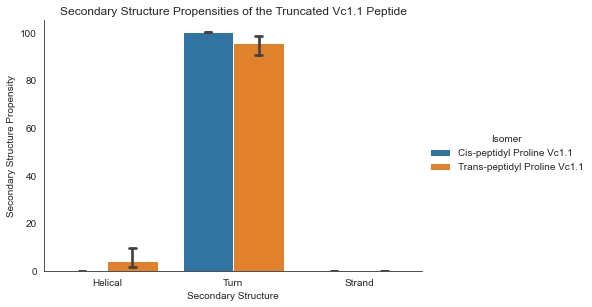

In [71]:
insulinSecStrucList = ['resid 1 to 9']
columnName = ['Secondary Structure Propensity']

# [1]
trajCount = 0
for traj in trajListFullNames:
    trajName = traj + "Traj"
    fullList = getSecStrucDF(trajName, insulinSecStrucList, columnName)
    trajDF = makeSecStrucDF(fullList, traj)
    if trajCount == 0:
        concatDF = trajDF
    else:
        concatDF = pd.concat([concatDF, trajDF])
    trajCount += 1

# [2]
for value in fullTrajNameDict:
    concatDF.loc[(concatDF.Isomer == value),'Isomer']=fullTrajNameDict[value]

# [3]
sns.catplot(data=concatDF, x="Secondary Structure", y="Secondary Structure Propensity", hue="Isomer", kind="bar", capsize=0.05, height=4, aspect=1.5)
plt.title('Secondary Structure Propensities of the Truncated Vc1.1 Peptide')

plt.savefig(imagePath + 'SecStruc.png', bbox_inches="tight")

With that complete, we're done with our introduction to Python analysis! This is by no means comprehensive, but it should function as an introduction as to how this sort of work is performed.